In [5]:
import numpy as np
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
import matplotlib.pyplot as plt
from minigrid.wrappers import RGBImgObsWrapper
# from gymnasium.wrappers import RecordVideo

In [6]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=8,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.render_mode = "rgb_array"
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate vertical separation wall
        for i in range(0, height):
            self.grid.set(5, i, Wall())
        
        # Place the door and key
        self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
        self.grid.set(3, 6, Key(COLOR_NAMES[0]))

        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), width - 2, height - 2)

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

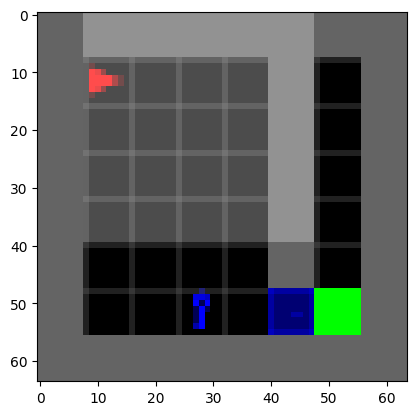

In [7]:
env = SimpleEnv()
env = RGBImgObsWrapper(env)
obs, _ = env.reset()
plt.imshow(obs['image'])